In [ ]:
import os
import sys
import torch
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, TensorDataset
import numpy as np
from scipy import linalg
import pickle
import tqdm
import matplotlib.pyplot as plt

In [ ]:
root = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
sys.path.insert(0, os.path.join(root, 'src'))

from dataset.synthetic_ecg import generate_ecg
from cs.wavelet_basis import wavelet_basis
from cs.supports import find_support_TSOC
from cs.neural import TSOC, multiclass_loss_alpha, compute_metrics, update_metrics
from cs import CompressedSensing, generate_sensing_matrix

# <span style="color: red;">TODO</span>
- Which training hyperparameters should I use: ``optimizer``, ``batch_size``, ``learning_rate``?
- Should I scale $X$ before training?
- Orthonormalize $A$.

## Setup

In [3]:
n = 128
m = 32
epochs = 500
lr = 0.1
batch_size = 50
N = 600_000
basis = 'sym6'       
fs = 256                # sampling rate
heart_rate = (60, 100)  # min and max heart rate
isnr = 35               # signal-to-noise ratio in dB (35)
seed = 0            # random seed for ECG generation
processes = 48
threshold = 0.5
gpu = 2
train_fraction = 0.9

## Seeds

In [4]:
np.random.seed(seed)

# Set the seed for PyTorch (CPU)
torch.manual_seed(seed)

# Set the seed for PyTorch (GPU)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

## GPU

In [5]:
device = torch.device(f'cuda:{gpu}' if torch.cuda.is_available() else 'cpu')

## Data

In [ ]:
file_name = f'ecg_train_N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
                f'_isnr={isnr}_seed={seed}.pkl'
data_path = os.path.join('training_data', file_name)
if os.path.exists(data_path):
    with open(data_path, 'rb') as f:
        X = pickle.load(f)

else:
    X = generate_ecg(
        length=n, 
        num_traces=N,
        heart_rate=heart_rate, 
        sampling_rate=fs, 
        snr=isnr, 
        random_state=seed,
        verbose=True,
        processes=processes,
    )
    with open(data_path, 'wb') as f:
        pickle.dump(X, f)

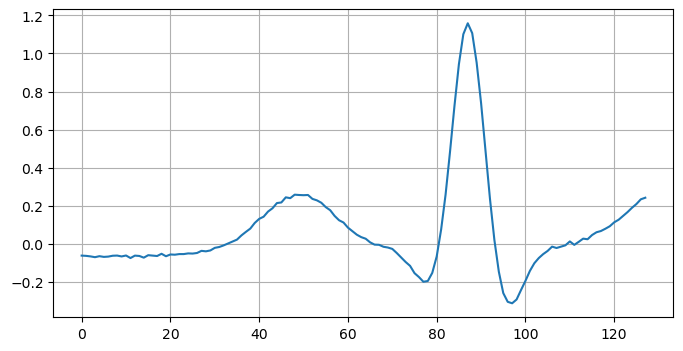

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(X[20])
ax.grid()

In [8]:
D = wavelet_basis(n, basis, level=2)

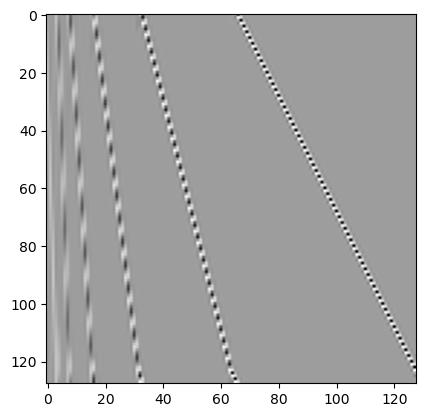

In [9]:
fig, ax = plt.subplots()
ax.imshow(D, cmap='gray')

In [10]:
A = generate_sensing_matrix((m, n), seed=seed)
cs = CompressedSensing(A, D)
Y = cs.encode(X)  # measurements

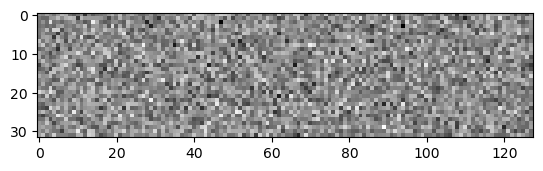

In [11]:
fig, ax = plt.subplots()
ax.imshow(A, cmap='gray')

In [14]:
file_name = f'support_train_N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
                f'_isnr={isnr}_seed={seed}.pkl'
data_path = os.path.join('training_data', file_name)
if os.path.exists(data_path):
    with open(data_path, 'rb') as f:
        Z = pickle.load(f)
else:
    Z = np.array([find_support_TSOC(x, cs) for x in X])
    with open(data_path, 'wb') as f:
        pickle.dump(Z, f)

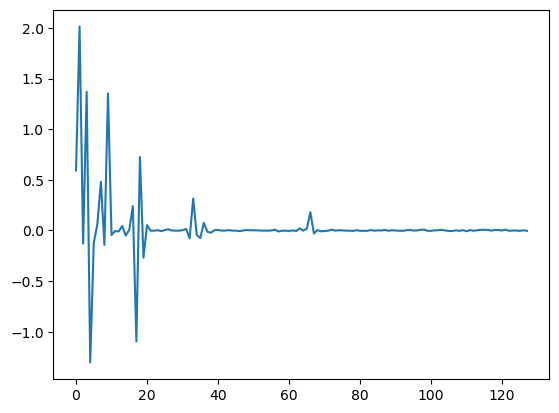

In [15]:
fig, ax = plt.subplots()
ax.plot(XI[0])

In [16]:
dataset = TensorDataset(torch.from_numpy(Y).float(), torch.from_numpy(Z).float())  # Create a dataset from the tensors
# Split sizes for training and validation
train_size = int(train_fraction * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

# Split the dataset
generator = torch.Generator()
generator.manual_seed(seed)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# Y_val, Z_val = zip(*val_dataset)
# Y_val = torch.stack(Y_val)  # Combine list of tensors into one tensor
# Z_val = torch.stack(Z_val)

## Network

In [17]:
tsoc = TSOC(n, m)
tsoc.to(device) # move the network to GPU
print(tsoc)
file_model = f'TSOC-N={N}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
                f'_isnr={isnr}_seed={seed}-epochs={epochs}-bs={batch_size}-lr={lr}.pth'

TSOC(
  (fc1): Linear(in_features=32, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
)


## Callbacks

In [18]:
# TODO

## Training

In [22]:
if os.path.exists(file_model):
    tsoc.load_state_dict(torch.load(file_model, weights_only=True))
else:
    optimizer = optim.SGD(tsoc.parameters(), lr=lr)
    # loss_fn = ClippedCrossEntropyLoss()

    for epoch in range(epochs):
        # train loop
        tsoc.train()     # Set the model to training mode
        train_loss = 0.0
        train_metrics = {'P': 0.0, 'TP': 0.0, 'TPR': 0.0, 'TNR': 0.0, 'ACC': 0.0}
        for batch_idx, (Y_batch, Z_batch) in enumerate(train_loader):
            Y_batch, Z_batch = Y_batch.to(device), Z_batch.to(device)     # move training data to GPU
            output = tsoc(Y_batch)
            loss = multiclass_loss_alpha(output, Z_batch)
            train_metrics_batch = compute_metrics(output, Z_batch, th=threshold)
            optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
            loss.backward()     # Backpropagate
            optimizer.step()     # Update weights
            train_loss += loss.item()
            train_metrics = update_metrics(train_metrics, train_metrics_batch)

        num_batches = len(train_loader)
        train_loss = train_loss/num_batches
        train_metrics = {key: value / num_batches for key, value in train_metrics.items()}

        # validation loop
        tsoc.eval()     # Set the model to evaluation mode
        val_loss = 0.0
        val_metrics = {'P': 0.0, 'TP': 0.0, 'TPR': 0.0, 'TNR': 0.0, 'ACC': 0.0}
        with torch.no_grad():     # disables gradient calculation for the validation phase 
            for batch_idx, (Y_batch, Z_batch) in enumerate(val_loader):
                Y_batch, Z_batch = Y_batch.to(device), Z_batch.to(device)     # move validation data to GPU
                output = tsoc(Y_batch)
                val_loss += multiclass_loss_alpha(output, Z_batch).item()
                val_metrics_batch = compute_metrics(output, Z_batch, th=threshold)
                val_metrics = update_metrics(val_metrics, val_metrics_batch)

        num_batches = len(val_loader)
        val_loss = val_loss/num_batches
        val_metrics = {key: value / num_batches for key, value in val_metrics.items()}
        print(f"Epoch [{epoch+1}/{epochs}], TRAIN Loss: {np.round(train_loss, 3)}  " +\
               "  ".join([f'{key}: {np.round(value, 3)}' for key, value in train_metrics.items()])  +\
                f"\n\t\tVAL Loss: {np.round(val_loss, 3)}  " +\
                    "  ".join([f'{key}: {np.round(value, 3)}' for key, value in val_metrics.items()]) + "\n") 


    torch.save(tsoc.state_dict(), file_model)

In [23]:
Y_val, Z_val = zip(*val_dataset)
Y_val = torch.stack(Y_val)  # Combine list of tensors into one tensor
Z_val = torch.stack(Z_val)

Y_val, Z_val = Y_val.to(device), Z_val.to(device)     # move validation data to GPU
output = tsoc(Y_val)
val_metrics = compute_metrics(output, Z_val, th=threshold)

In [24]:
val_metrics

{'P': 25.0671329498291,
 'TP': 23.292116165161133,
 'TPR': 0.9322579503059387,
 'TNR': 0.9889966249465942,
 'ACC': 0.9770447015762329}

## Recovery

In [25]:
B = A @ D

def decoder2(out, y):
    zhat = out > threshold
    BTS = np.linalg.pinv(B[:, zhat])
    xihat = BTS @ y
    xhat = D[:, zhat] @ xihat
    return xhat

def rsnr(x, xhat):
    return 10*np.log10(np.sum(x**2, axis=-1)/np.sum((x - xhat)**2, axis=-1))


In [26]:
O = tsoc(Y_val.to(device))
O = O.cpu().detach().numpy() # Moves the tensor from the GPU to the CPU,
# removes it from the computation graph and converts it to numpy array

<a list of 128 BarContainer objects>

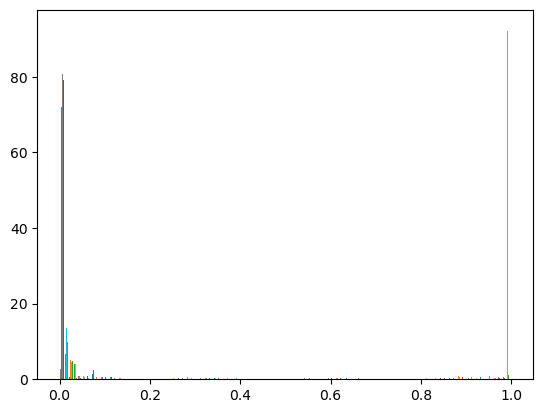

In [27]:
fig, ax = plt.subplots()
ax.hist(O, bins = 100, density=True)[-1]

In [44]:
X_val = X[val_dataset.indices]
Y_val = Y_val.cpu().detach().numpy()

In [45]:
Xhat = np.empty((len(val_dataset), X_val.shape[1]))
for i in tqdm.tqdm(range(len(val_dataset))):
    Xhat[i] = decoder2(O[i], Y_val[i])

100%|██████████| 60000/60000 [00:24<00:00, 2492.30it/s]


In [46]:
RSNR = rsnr(X_val, Xhat)
np.mean(RSNR)

25.310660489469374

28.765295930630586


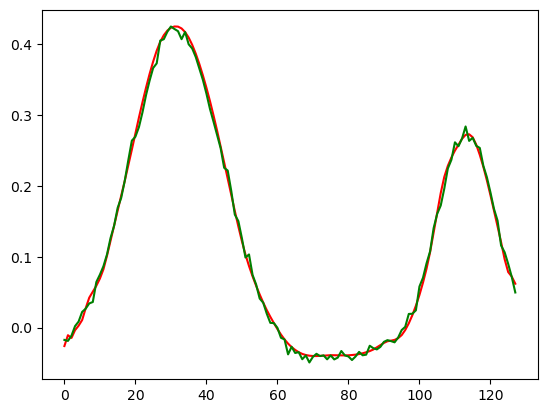

In [48]:
fig, ax = plt.subplots()
ax.plot(Xhat[20], c='r')
ax.plot(X_val[20], c='g')
print(RSNR[20])